<a href="https://colab.research.google.com/github/eghib22/I-m-Something-of-a-Painter-Myself/blob/main/CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle
! pip install wandb
import wandb

In [2]:
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle

from google.colab import files
files.upload()

!mv "kaggle.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!ls -l ~/.kaggle/
!kaggle competitions download -c gan-getting-started
!unzip -q gan-getting-started.zip -d data
!ls data
wandb.login()

Mounted at /content/drive


Saving kaggle.json to kaggle.json
total 4
-rw------- 1 root root 74 Dec 18 23:18 kaggle.json
 77% 284M/367M [00:00<00:00, 822MB/s] 
100% 367M/367M [00:00<00:00, 561MB/s]
monet_jpg  monet_tfrec	photo_jpg  photo_tfrec


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: eghib22 (eghib22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
import os
import random
import itertools
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt


In [26]:
class Config:
    image_size = 256
    batch_size = 1
    num_workers = 2
    lr = 2e-4
    epochs = 60
    lambda_cycle = 10.0
    lambda_identity = 5.0
    device = "cuda" if torch.cuda.is_available() else "cpu"

cfg = Config()


In [6]:
class MonetPhotoDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, transform=None):
        self.monet_paths = sorted(os.listdir(monet_dir))
        self.photo_paths = sorted(os.listdir(photo_dir))
        self.monet_dir = monet_dir
        self.photo_dir = photo_dir
        self.transform = transform

    def __len__(self):
        return len(self.monet_paths)


    def __getitem__(self, idx):
        monet_path = os.path.join(
            self.monet_dir,
            self.monet_paths[idx % len(self.monet_paths)]
        )
        photo_path = os.path.join(
            self.photo_dir,
            self.photo_paths[random.randint(0, len(self.photo_paths) - 1)]
        )

        monet = Image.open(monet_path).convert("RGB")
        photo = Image.open(photo_path).convert("RGB")

        if self.transform:
            monet = self.transform(monet)
            photo = self.transform(photo)

        return {"monet": monet, "photo": photo}

In [7]:
transform = transforms.Compose([
    transforms.Resize(286),
    transforms.RandomCrop(cfg.image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [8]:
dataset = MonetPhotoDataset(
    "data/monet_jpg",
    "data/photo_jpg",
    transform
)

loader = DataLoader(
    dataset,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=cfg.num_workers
)


In [10]:
@torch.no_grad()
def save_samples(epoch):
    G.eval()
    batch = next(iter(loader))
    real_photo = batch["photo"].to(cfg.device)
    fake_monet = G(real_photo)

    grid = make_grid(fake_monet[:4], nrow=4, normalize=True)
    plt.figure(figsize=(8, 4))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis("off")
    plt.show()
    plt.title(f"Epoch {epoch}")
    G.train()

In [11]:
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)


In [12]:
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, n_blocks=9):
        super().__init__()

        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(True)
        ]

        # Downsample
        in_features = 64
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, in_features * 2, 3, stride=2, padding=1),
                nn.InstanceNorm2d(in_features * 2),
                nn.ReLU(True)
            ]
            in_features *= 2

        # Residual blocks
        for _ in range(n_blocks):
            model += [ResnetBlock(in_features)]

        # Upsample
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, in_features // 2, 3, stride=2,
                                   padding=1, output_padding=1),
                nn.InstanceNorm2d(in_features // 2),
                nn.ReLU(True)
            ]
            in_features //= 2

        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_nc, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


In [14]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_nc=3):
        super().__init__()

        def block(in_c, out_c, stride=2, norm=True):
            layers = [nn.Conv2d(in_c, out_c, 4, stride=stride, padding=1)]
            if norm:
                layers.append(nn.InstanceNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, True))
            return layers

        self.model = nn.Sequential(
            *block(input_nc, 64, norm=False),
            *block(64, 128),
            *block(128, 256),
            *block(256, 512, stride=1),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)


In [15]:
class LSGANLoss:
    def __init__(self):
        self.loss = nn.MSELoss()

    def __call__(self, preds, target_is_real):
        if target_is_real:
            target = torch.ones_like(preds)
        else:
            target = torch.zeros_like(preds)
        return self.loss(preds, target)


In [16]:
cycle_loss_fn = nn.L1Loss()
identity_loss_fn = nn.L1Loss()
gan_loss_fn = LSGANLoss()


In [17]:
G = ResnetGenerator().to(cfg.device)  # Photo → Monet
F = ResnetGenerator().to(cfg.device)  # Monet → Photo

D_monet = PatchDiscriminator().to(cfg.device)
D_photo = PatchDiscriminator().to(cfg.device)


In [18]:
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.InstanceNorm2d):
        if m.weight is not None:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

G.apply(init_weights)
F.apply(init_weights)
D_monet.apply(init_weights)
D_photo.apply(init_weights)


PatchDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [19]:
g_optimizer = torch.optim.Adam(
    itertools.chain(G.parameters(), F.parameters()),
    lr=cfg.lr,
    betas=(0.5, 0.999)
)

d_monet_optimizer = torch.optim.Adam(
    D_monet.parameters(), lr=cfg.lr, betas=(0.5, 0.999)
)

d_photo_optimizer = torch.optim.Adam(
    D_photo.parameters(), lr=cfg.lr, betas=(0.5, 0.999)
)


In [20]:
wandb.login()

True

In [21]:
wandb.init(
    project="monet-cyclegan",
    config=vars(cfg)
)


In [22]:
import os

checkpoint_dir = "/content/drive/MyDrive/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
start_epoch = 0

g_path = os.path.join(checkpoint_dir, "G_latest.pth")
f_path = os.path.join(checkpoint_dir, "F_latest.pth")

if os.path.exists(g_path) and os.path.exists(f_path):
    print("🔁 Resuming from latest checkpoint")
    G.load_state_dict(torch.load(g_path, map_location=cfg.device))
    F.load_state_dict(torch.load(f_path, map_location=cfg.device))


In [24]:
class ImagePool:
    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        self.images = []

    def query(self, images):
        result = []
        for image in images:
            image = image.unsqueeze(0)
            if len(self.images) < self.pool_size:
                self.images.append(image)
                result.append(image)
            else:
                if random.random() > 0.5:
                    idx = random.randint(0, self.pool_size - 1)
                    tmp = self.images[idx].clone()
                    self.images[idx] = image
                    result.append(tmp)
                else:
                    result.append(image)
        return torch.cat(result, dim=0)


In [25]:
fake_monet_pool = ImagePool(50)
fake_photo_pool = ImagePool(50)



🚀 Starting epoch 1/60
[Epoch 1/60] [Batch 0/300] G: 5.960 | Cycle: 3.613 | Id: 1.573 | D_M: 0.226 | D_P: 0.421
[Epoch 1/60] [Batch 100/300] G: 6.299 | Cycle: 4.008 | Id: 2.081 | D_M: 0.278 | D_P: 0.236
[Epoch 1/60] [Batch 200/300] G: 6.604 | Cycle: 4.105 | Id: 1.665 | D_M: 0.099 | D_P: 0.239


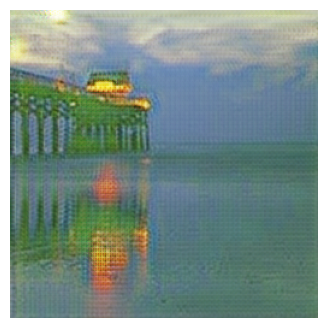


🚀 Starting epoch 2/60
[Epoch 2/60] [Batch 0/300] G: 7.828 | Cycle: 4.174 | Id: 2.047 | D_M: 0.461 | D_P: 0.280
[Epoch 2/60] [Batch 100/300] G: 7.300 | Cycle: 4.019 | Id: 2.150 | D_M: 0.383 | D_P: 0.484
[Epoch 2/60] [Batch 200/300] G: 5.096 | Cycle: 2.771 | Id: 1.334 | D_M: 0.074 | D_P: 0.144


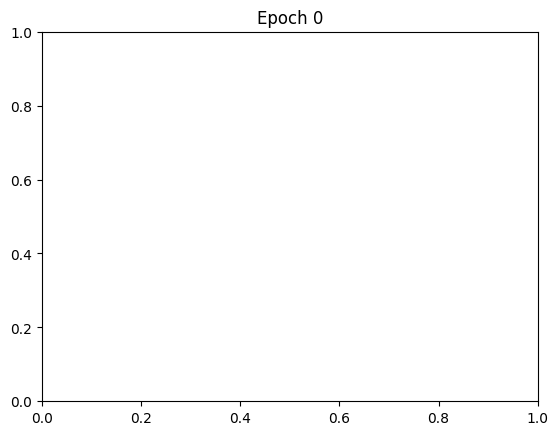

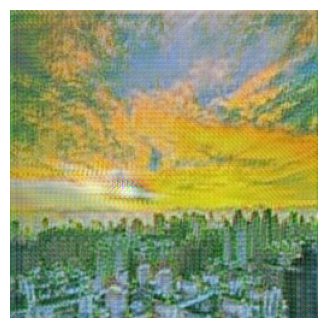


🚀 Starting epoch 3/60
[Epoch 3/60] [Batch 0/300] G: 7.296 | Cycle: 4.636 | Id: 2.035 | D_M: 0.283 | D_P: 0.178
[Epoch 3/60] [Batch 100/300] G: 6.659 | Cycle: 4.069 | Id: 1.590 | D_M: 0.197 | D_P: 0.152
[Epoch 3/60] [Batch 200/300] G: 4.543 | Cycle: 2.935 | Id: 1.335 | D_M: 0.384 | D_P: 0.338


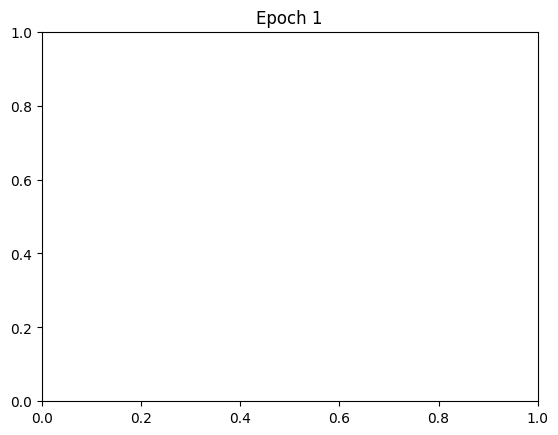

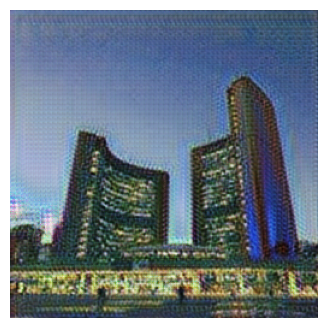


🚀 Starting epoch 4/60
[Epoch 4/60] [Batch 0/300] G: 4.682 | Cycle: 2.851 | Id: 1.225 | D_M: 0.171 | D_P: 0.182
[Epoch 4/60] [Batch 100/300] G: 4.754 | Cycle: 2.492 | Id: 1.678 | D_M: 0.234 | D_P: 0.130
[Epoch 4/60] [Batch 200/300] G: 5.920 | Cycle: 3.493 | Id: 1.539 | D_M: 0.158 | D_P: 0.168


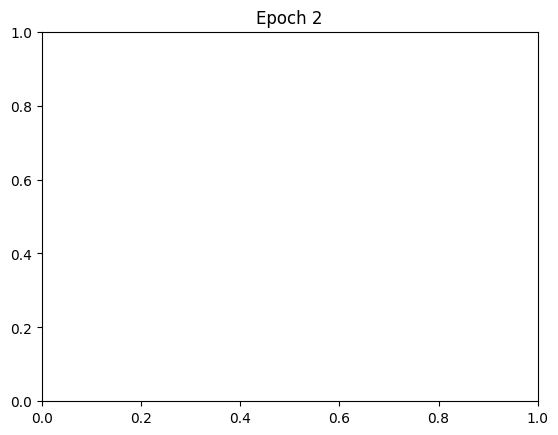

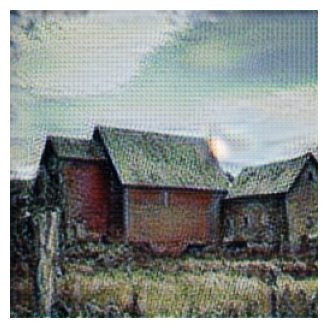


🚀 Starting epoch 5/60
[Epoch 5/60] [Batch 0/300] G: 4.180 | Cycle: 2.183 | Id: 1.174 | D_M: 0.381 | D_P: 0.552
[Epoch 5/60] [Batch 100/300] G: 5.850 | Cycle: 3.673 | Id: 1.367 | D_M: 0.146 | D_P: 0.175
[Epoch 5/60] [Batch 200/300] G: 4.683 | Cycle: 2.683 | Id: 1.260 | D_M: 0.329 | D_P: 0.274


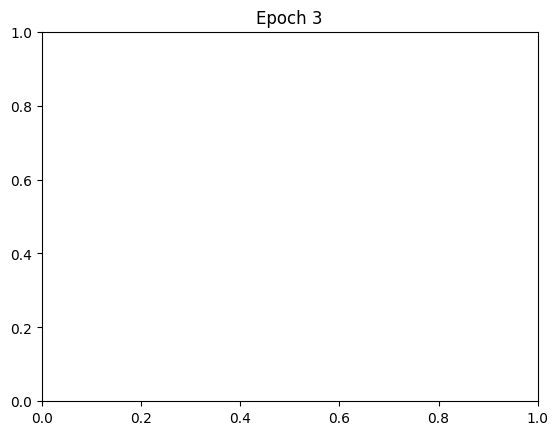

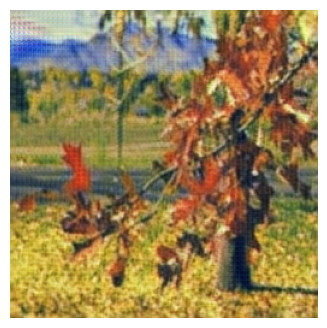


🚀 Starting epoch 6/60
[Epoch 6/60] [Batch 0/300] G: 5.918 | Cycle: 3.536 | Id: 1.504 | D_M: 0.167 | D_P: 0.271
[Epoch 6/60] [Batch 100/300] G: 5.443 | Cycle: 3.028 | Id: 1.448 | D_M: 0.093 | D_P: 0.272
[Epoch 6/60] [Batch 200/300] G: 8.192 | Cycle: 4.981 | Id: 2.724 | D_M: 0.643 | D_P: 0.140


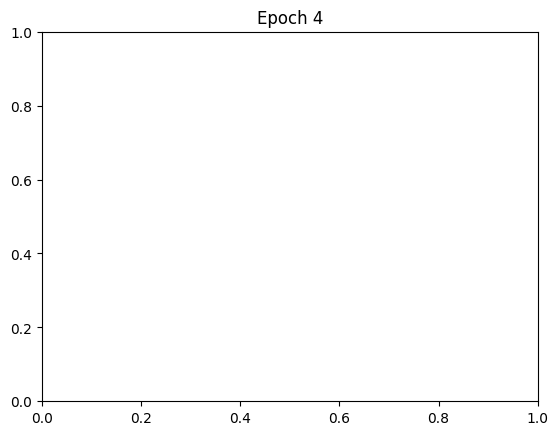

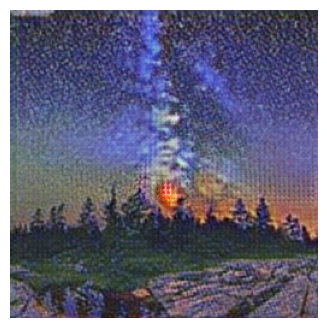


🚀 Starting epoch 7/60
[Epoch 7/60] [Batch 0/300] G: 6.027 | Cycle: 3.763 | Id: 1.719 | D_M: 0.268 | D_P: 0.126
[Epoch 7/60] [Batch 100/300] G: 4.320 | Cycle: 2.463 | Id: 1.200 | D_M: 0.152 | D_P: 0.426


In [ ]:
num_batches = len(loader)

for epoch in range(cfg.epochs):
    print(f"\n🚀 Starting epoch {epoch+1}/{cfg.epochs}")

    for i, batch in enumerate(loader):
        real_monet = batch["monet"].to(cfg.device)
        real_photo = batch["photo"].to(cfg.device)

        # =========================
        # Train Generators
        # =========================
        g_optimizer.zero_grad()

        fake_monet = G(real_photo)
        rec_photo = F(fake_monet)

        fake_photo = F(real_monet)
        rec_monet = G(fake_photo)

        loss_g_photo = gan_loss_fn(D_monet(fake_monet), True)
        loss_g_monet = gan_loss_fn(D_photo(fake_photo), True)

        loss_cycle = (
            cycle_loss_fn(rec_photo, real_photo) +
            cycle_loss_fn(rec_monet, real_monet)
        ) * cfg.lambda_cycle

        id_photo = F(real_photo)
        id_monet = G(real_monet)

        loss_identity = (
            identity_loss_fn(id_photo, real_photo) +
            identity_loss_fn(id_monet, real_monet)
        ) * cfg.lambda_identity

        loss_G = loss_g_photo + loss_g_monet + loss_cycle + loss_identity
        loss_G.backward()
        g_optimizer.step()

        # =========================
        # Train Discriminator Monet
        # =========================
        d_monet_optimizer.zero_grad()

        loss_d_monet_real = gan_loss_fn(D_monet(real_monet), True)
        fake_monet_buffer = fake_monet_pool.query(fake_monet.detach())
        loss_d_monet_fake = gan_loss_fn(D_monet(fake_monet_buffer), False)

        loss_D_monet = (loss_d_monet_real + loss_d_monet_fake) * 0.5

        loss_D_monet.backward()
        d_monet_optimizer.step()

        # =========================
        # Train Discriminator Photo
        # =========================
        d_photo_optimizer.zero_grad()

        loss_d_photo_real = gan_loss_fn(D_photo(real_photo), True)
        fake_photo_buffer = fake_photo_pool.query(fake_photo.detach())
        loss_d_photo_fake = gan_loss_fn(D_photo(fake_photo_buffer), False)

        loss_D_photo = (loss_d_photo_real + loss_d_photo_fake) * 0.5

        loss_D_photo.backward()
        d_photo_optimizer.step()

        # =========================
        # Logging + PRINTS
        # =========================
        if i % 100 == 0:
            print(
                f"[Epoch {epoch+1}/{cfg.epochs}] "
                f"[Batch {i}/{num_batches}] "
                f"G: {loss_G.item():.3f} | "
                f"Cycle: {loss_cycle.item():.3f} | "
                f"Id: {loss_identity.item():.3f} | "
                f"D_M: {loss_D_monet.item():.3f} | "
                f"D_P: {loss_D_photo.item():.3f}"
            )

            wandb.log({
                "loss_G": loss_G.item(),
                "loss_cycle": loss_cycle.item(),
                "loss_identity": loss_identity.item(),
                "loss_D_monet": loss_D_monet.item(),
                "loss_D_photo": loss_D_photo.item(),
                "epoch": epoch,
                "step": epoch * num_batches + i
            })
    save_samples(epoch)
    torch.save(G.state_dict(), f"{checkpoint_dir}/G_latest.pth")
    torch.save(F.state_dict(), f"{checkpoint_dir}/F_latest.pth")


